In [8]:
import sys
if not '../..' in sys.path:
    sys.path.append('../..')
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import colormaps
from analysis import collection, analysis, emg, plot
import scipy as sp
import pandas as pd
import pickle
from pathlib import Path
import seaborn as sns
# import swifter

# from tqdm import tqdm
# tqdm.pandas()

# from swifter import set_defaults
# set_defaults(
#     npartitions=12,
#     dask_threshold=2,
#     scheduler="processes",
#     progress_bar=True,
#     progress_bar_desc=None,
#     allow_dask_on_strings=False,
#     force_parallel=True,
# )


mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update({'axes.labelsize': 16})
mpl.rcParams.update({'figure.figsize': (16*0.8,9*0.8)})
mpl.rcParams.update({'axes.facecolor': "white"})
mpl.rcParams.update({'lines.marker': "+"})
mpl.rcParams.update({'lines.linestyle': ""})
mpl.rcParams.update({"axes.spines.left":   True})
mpl.rcParams.update({"axes.spines.bottom": True})
mpl.rcParams.update({"axes.spines.top":    False})
mpl.rcParams.update({"axes.spines.right":  False})

image_path = Path("/Users/spencer/phd/phd/images/basic_results/trial_reward")

%matplotlib inline

# this compute the reward / error for each subject -- VERY SLOW!

In [2]:
channels = np.arange(2)
n_timepoints = 2000
timepoints = np.arange(n_timepoints)
n_targets = 12
target_numbers = range(1,n_targets+1)
n_blocks = 45
blocks = range(n_blocks)
n_subjects = 46
subjects = range(n_subjects)

multi_index = pd.MultiIndex.from_product([subjects,blocks,target_numbers,timepoints],names=["subject","block","target","time"])
print(multi_index.shape)
subject_traj_stacks = np.load("subject_filtered_trajectory_stacks.npy").transpose(0,1,2,4,3)
print(subject_traj_stacks.shape)
df = pd.DataFrame(subject_traj_stacks.reshape(-1,2),index=multi_index,columns=channels).dropna()
del subject_traj_stacks
print(df.shape)

(49680000,)
(46, 45, 12, 2000, 2)
(7989403, 2)


In [3]:
# make everything numpy for HUGE speedups!
target_vecs = np.array([collection.compute_target_vec_from_number(target_number) for target_number in range(1,13)])

def compute_reward(row):
    return np.linalg.norm(row.to_numpy() - target_vecs[row.name[2] - 1])

In [4]:
df["reward"] = df.swifter.apply(compute_reward,axis='columns',result_type="expand")

Pandas Apply: 100%|██████████| 7989403/7989403 [01:07<00:00, 118326.73it/s]
/tmp/ipykernel_14632/3822169844.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["reward"] = df.swifter.apply(compute_reward,axis='columns',result_type="expand")


In [16]:
subject_means = df.groupby(level=["subject"]).mean()["reward"].to_numpy()

In [17]:
subject_means

array([0.73099753, 0.91790218, 1.07413579, 0.83975535, 1.64866241,
       1.10260095, 0.64802526, 1.17657013, 1.1124183 , 1.06453238,
       0.98989446, 0.73068902, 1.31006926, 1.14054334, 0.87087456,
       0.83560084, 0.74009076, 0.81439326, 0.91261121, 1.10256106,
       1.31260078, 0.8731727 , 0.76335023, 2.03272531, 0.83820096,
       1.20565439, 1.47434129, 0.94514226, 1.10814163, 0.51741588,
       0.91681046, 0.95579013, 0.82276626, 0.82240779, 1.49835347,
       0.7867887 , 0.78904761, 0.70650151, 1.13983938, 1.31562858,
       0.9062382 , 0.86533955, 0.92182935, 1.01408642, 1.00768263,
       1.20706692])

In [19]:
np.argsort(subject_means**-1)[::-1]

array([29,  6, 37, 11,  0, 16, 22, 35, 36, 17, 33, 32, 15, 24,  3, 41, 14,
       21, 40, 18, 30,  1, 42, 27, 31, 10, 44, 43,  9,  2, 19,  5, 28,  8,
       38, 13,  7, 25, 45, 12, 20, 39, 26, 34,  4, 23])

In [20]:
df.to_pickle("trajectory_dataframe.pkl")

# loading the previously computed mean reward

In [2]:
with open("../trajectory_dataframe.pkl",'rb') as handle:
    trajectory_df = pd.read_pickle(handle)
subject_rewards = 1 / trajectory_df.groupby(level=['subject']).mean()["reward"]

In [3]:
subjects = analysis.load_subjects()

In [4]:
hit_fractions = analysis.compute_hit_fractions(subjects)

/opt/homebrew/Caskroom/miniconda/base/envs/data/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0, 0.5, 'Subject Count')

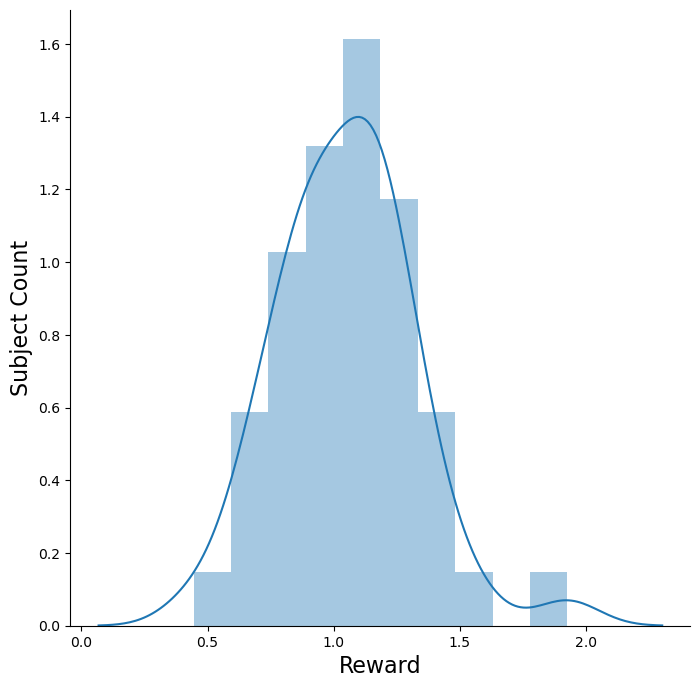

In [13]:
reward_hist = plt.figure(figsize=(8,8))
sns.kdeplot(subject_rewards,marker="",linestyle="-")
plt.hist(subject_rewards,color="tab:blue",alpha=0.4,density=True,bins=10)
plt.xlabel("Reward")
plt.ylabel("Subject Count")

In [14]:
plot.save_figure(reward_hist, "reward_histogram", image_path)

Figure saved to /Users/spencer/phd/phd/images/basic_results/trial_reward/reward_histogram.pdf


/opt/homebrew/Caskroom/miniconda/base/envs/data/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0, 0.5, 'Subject Count')

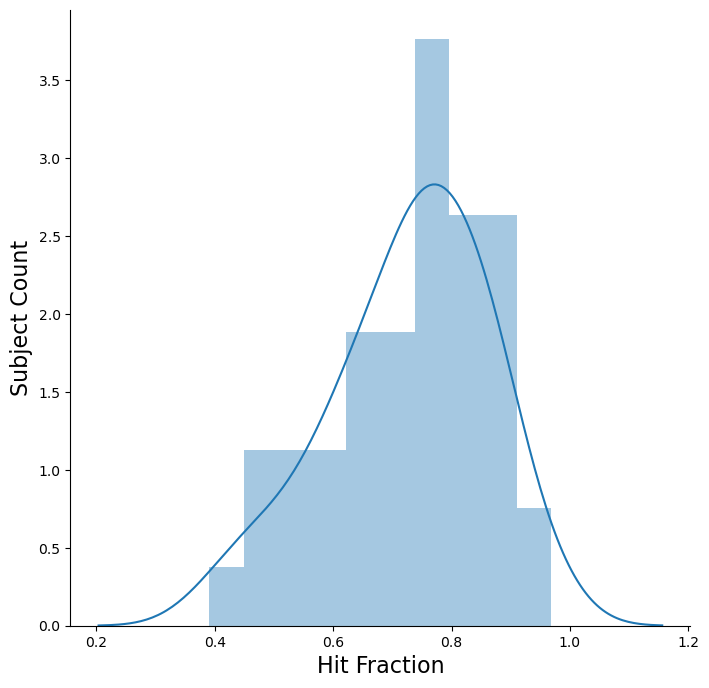

In [15]:
hit_fraction_hist = plt.figure(figsize=(8,8))
sns.kdeplot(hit_fractions,marker="",linestyle="-")
plt.hist(hit_fractions,color="tab:blue",alpha=0.4,density=True,bins=10)
plt.xlabel("Hit Fraction")
plt.ylabel("Subject Count")

In [16]:
plot.save_figure(hit_fraction_hist, "hit_fraction_histogram", image_path)

Figure saved to /Users/spencer/phd/phd/images/basic_results/trial_reward/hit_fraction_histogram.pdf
